In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


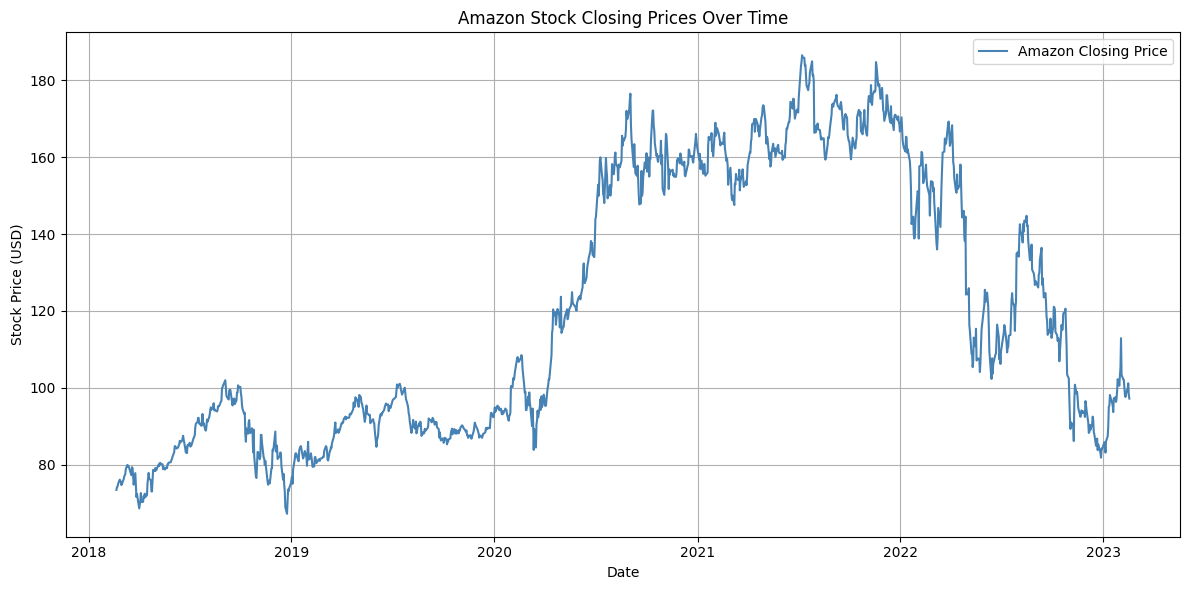

ADF Test p-value: 0.45297105465166737
KPSS Test p-value: 0.01
ADF (Differenced) p-value: 0.0
KPSS (Differenced) p-value: 0.1


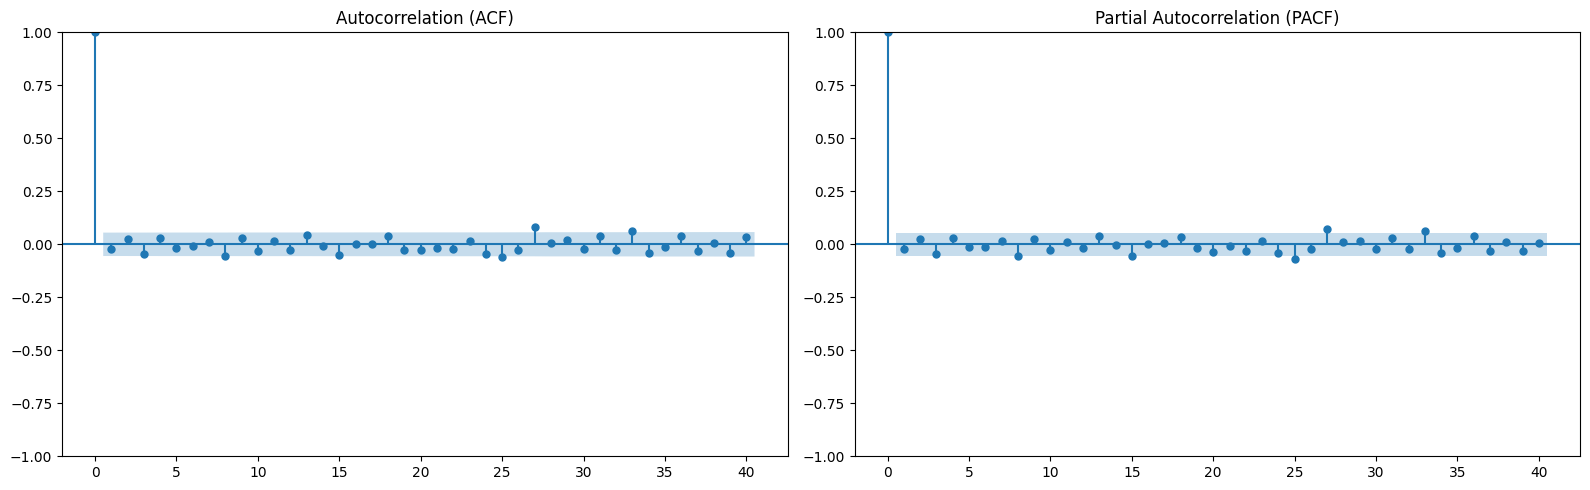

Best ARIMA Configuration (p,d,q): (2, 1, 2)
Model Evaluation on Last 24 Days:
MAE : 2.9318
RMSE: 4.2158
MAPE: 0.0285


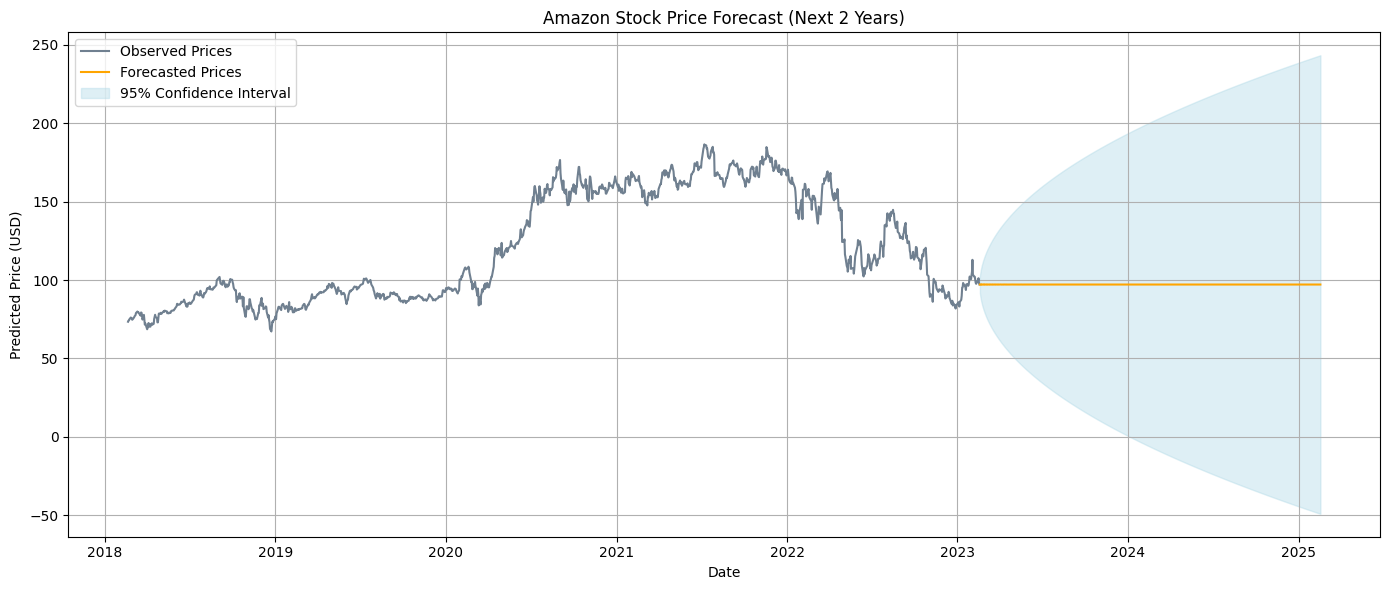

In [2]:
# --- Time Series Forecasting Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# -------------------------------------------------
# Step 1: Load Dataset and Plot Amazon Stock Prices
# -------------------------------------------------
stock_data = pd.read_csv("/content/drive/MyDrive/AMZN.csv")
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.set_index('Date', inplace=True)

# Select only the closing price column
close_prices = stock_data[['Close']]

# Visualize the time series
plt.figure(figsize=(12, 6))
plt.plot(close_prices, color='steelblue', label='Amazon Closing Price')
plt.title('Amazon Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------------------------
# Step 2: Perform ADF and KPSS Tests for Stationarity
# -----------------------------------------------
adf_test = adfuller(close_prices['Close'])
kpss_test = kpss(close_prices['Close'], regression='c', nlags='auto')

print("ADF Test p-value:", adf_test[1])
print("KPSS Test p-value:", kpss_test[1])

# ------------------------------------------------------
# Step 3: Apply Differencing to Make Series Stationary
# ------------------------------------------------------
diff_prices = close_prices.diff().dropna()

# Rerun stationarity tests on transformed data
adf_test_diff = adfuller(diff_prices['Close'])
kpss_test_diff = kpss(diff_prices['Close'], regression='c', nlags='auto')

print("ADF (Differenced) p-value:", adf_test_diff[1])
print("KPSS (Differenced) p-value:", kpss_test_diff[1])

# --------------------------------------
# Step 4: Visualize ACF and PACF Plots
# --------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(diff_prices, lags=40, ax=ax[0])
ax[0].set_title("Autocorrelation (ACF)")
plot_pacf(diff_prices, lags=40, ax=ax[1])
ax[1].set_title("Partial Autocorrelation (PACF)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Step 5: Grid Search to Determine Optimal ARIMA Parameters
# ---------------------------------------------------------
min_aic = np.inf
optimal_order = None
optimal_model = None

for p in range(4):
    for q in range(4):
        try:
            arima_model = ARIMA(close_prices['Close'], order=(p, 1, q)).fit()
            if arima_model.aic < min_aic:
                min_aic = arima_model.aic
                optimal_order = (p, 1, q)
                optimal_model = arima_model
        except:
            continue

print("Best ARIMA Configuration (p,d,q):", optimal_order)

# ----------------------------------------------------------
# Step 6: Predict the Next 730 Days (Approx. 2-Year Forecast)
# ----------------------------------------------------------
forecast_output = optimal_model.get_forecast(steps=730)
forecast_values = forecast_output.predicted_mean
forecast_bounds = forecast_output.conf_int()

final_date = close_prices.index[-1]
forecast_index = pd.date_range(start=final_date + pd.Timedelta(days=1), periods=730, freq='D')

# --------------------------------------------------
# Step 7: Train/Test Split for Performance Check
# --------------------------------------------------
test_len = 24
training_data = close_prices[:-test_len]
testing_data = close_prices[-test_len:]

# Fit model on training data
model_on_train = ARIMA(training_data['Close'], order=optimal_order).fit()
test_forecast_result = model_on_train.get_forecast(steps=test_len)
predicted_test_values = test_forecast_result.predicted_mean

# -------------------------------------------------------------
# Step 8: Calculate Evaluation Metrics for Model Performance
# -------------------------------------------------------------
actual_values = testing_data['Close'].values
forecasted_values = predicted_test_values.values

eval_mae = mean_absolute_error(actual_values, forecasted_values)
eval_rmse = np.sqrt(mean_squared_error(actual_values, forecasted_values))
eval_mape = mean_absolute_percentage_error(actual_values, forecasted_values)

print("Model Evaluation on Last 24 Days:")
print("MAE :", round(eval_mae, 4))
print("RMSE:", round(eval_rmse, 4))
print("MAPE:", round(eval_mape, 4))

# --------------------------------------------------
# Step 9: Plot Future Forecast with Confidence Intervals
# --------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(close_prices.index, close_prices['Close'], label='Observed Prices', color='slategray')
plt.plot(forecast_index, forecast_values, label='Forecasted Prices', color='orange')
plt.fill_between(forecast_index,
                 forecast_bounds.iloc[:, 0],
                 forecast_bounds.iloc[:, 1],
                 color='lightblue', alpha=0.4, label='95% Confidence Interval')
plt.title('Amazon Stock Price Forecast (Next 2 Years)')
plt.xlabel('Date')
plt.ylabel('Predicted Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**RNN and Lstm Model**

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.1029 - val_loss: 0.0073
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0014 - val_loss: 0.0042
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0

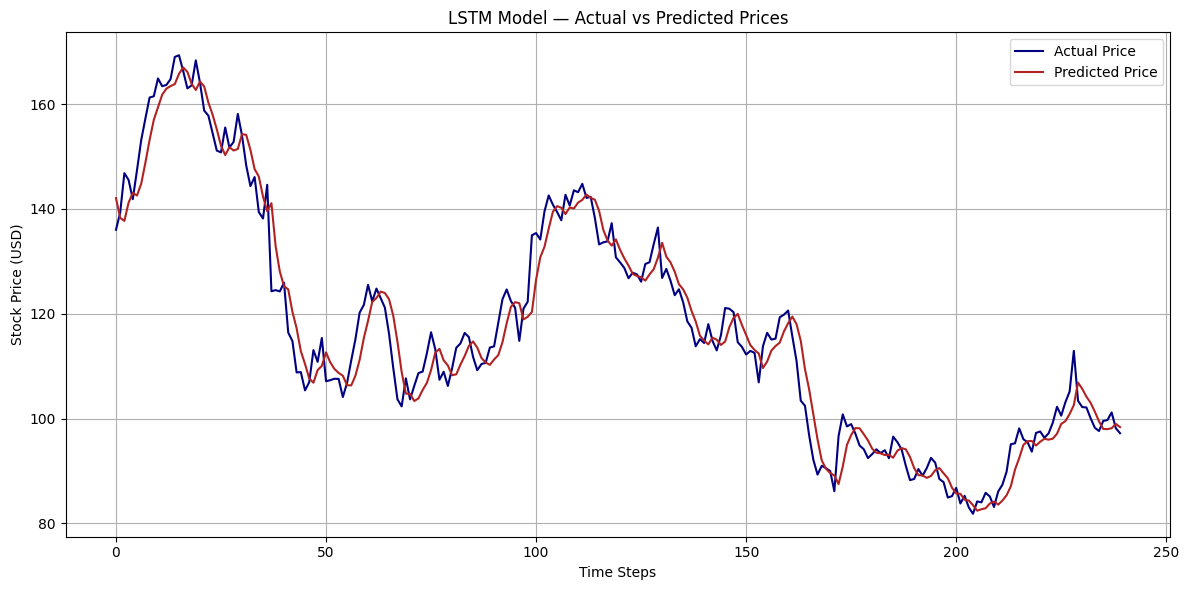

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
LSTM Forecasting Model Evaluation:
MAE : 3.5452
RMSE: 4.4938
MAPE: 0.0306


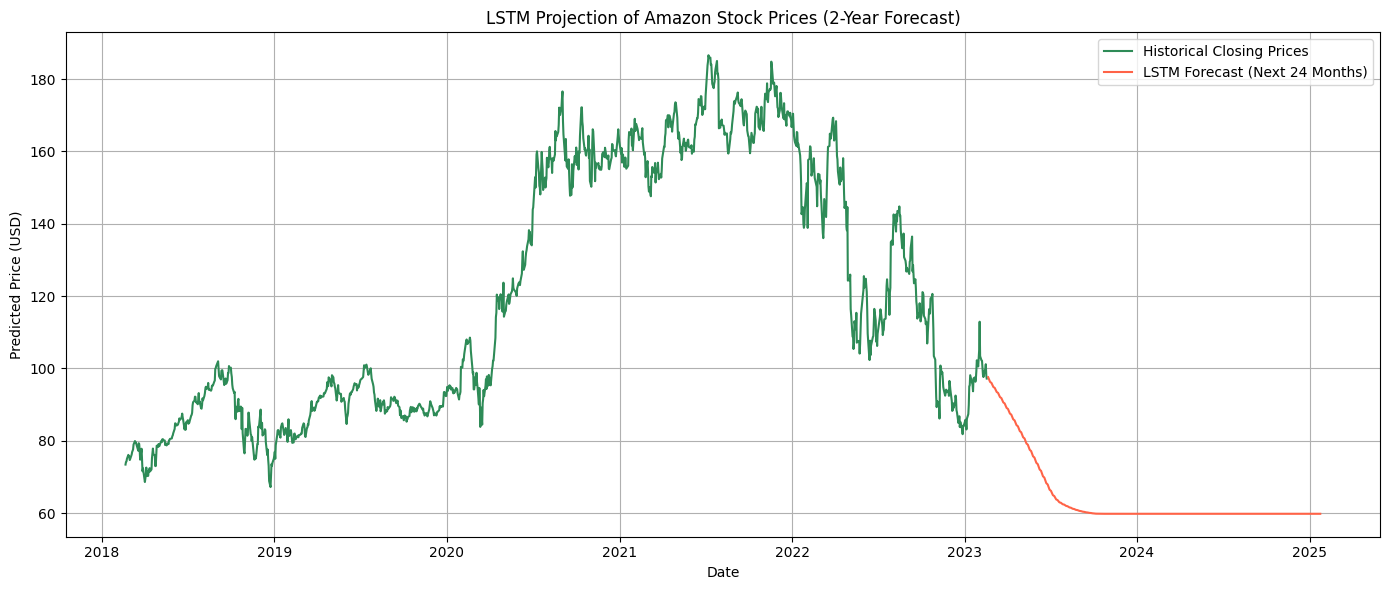

In [3]:
# ---------------------------------------------
# Required Libraries for LSTM Time Series Model
# ---------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

# ---------------------------------------------
# Step 1: Load Dataset and Normalize Close Prices
# ---------------------------------------------
df_stock = pd.read_csv("/content/drive/MyDrive/AMZN.csv")
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock.set_index('Date', inplace=True)

price_series = df_stock[['Close']].copy()

# Normalize closing prices for LSTM input
price_scaler = MinMaxScaler()
price_series['Close'] = price_scaler.fit_transform(price_series[['Close']])

# ------------------------------------------------
# Step 2: Generate Sequences for Supervised Learning
# ------------------------------------------------
def generate_sequences(series, window_size):
    inputs, targets = [], []
    for i in range(len(series) - window_size):
        inputs.append(series[i:i + window_size])
        targets.append(series[i + window_size])
    return np.array(inputs), np.array(targets)

window_length = 60
X_seq, y_seq = generate_sequences(price_series['Close'].values, window_length)
X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))

# ------------------------------------------------
# Step 3: Split Dataset into Training and Test Sets
# ------------------------------------------------
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# ------------------------------------------------
# Step 4: Build and Train the LSTM Neural Network
# ------------------------------------------------
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    callbacks=[stop_early],
    verbose=1
)

# ------------------------------------------------
# Step 5: Visualize Model Predictions vs True Values
# ------------------------------------------------
def plot_lstm_predictions(model, X_test, y_true, label="LSTM Model"):
    pred = model.predict(X_test)
    plt.figure(figsize=(12, 6))
    plt.plot(price_scaler.inverse_transform(y_true.reshape(-1, 1)), label='Actual Price', color='navy')
    plt.plot(price_scaler.inverse_transform(pred), label='Predicted Price', color='firebrick')
    plt.title(f"{label} — Actual vs Predicted Prices")
    plt.xlabel("Time Steps")
    plt.ylabel("Stock Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_lstm_predictions(lstm_model, X_test_seq, y_test_seq)

# ------------------------------------------------
# Step 6: Evaluate Model Using Performance Metrics
# ------------------------------------------------
y_pred_scaled = lstm_model.predict(X_test_seq)
actual_values = price_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
predicted_values = price_scaler.inverse_transform(y_pred_scaled).flatten()

eval_mae = mean_absolute_error(actual_values, predicted_values)
eval_rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
eval_mape = mean_absolute_percentage_error(actual_values, predicted_values)

print("LSTM Forecasting Model Evaluation:")
print("MAE :", round(eval_mae, 4))
print("RMSE:", round(eval_rmse, 4))
print("MAPE:", round(eval_mape, 4))

# ------------------------------------------------
# Step 7: Forecast Stock Prices for Next 24 Months
# ------------------------------------------------
def make_future_forecast(model, recent_data, steps=504, window_size=60):
    current_input = recent_data[-window_size:].reshape(1, window_size, 1)
    future_preds = []

    for _ in range(steps):
        next_value = model.predict(current_input, verbose=0)[0][0]
        future_preds.append(next_value)
        current_input = np.append(current_input[:, 1:, :], [[[next_value]]], axis=1)

    return price_scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

forecast_24m = make_future_forecast(lstm_model, price_series['Close'].values, steps=504)

# ------------------------------------------------
# Step 8: Create Timeline and Plot Future Forecast
# ------------------------------------------------
future_time_index = pd.date_range(start=price_series.index[-1] + pd.DateOffset(days=1), periods=504, freq='B')

plt.figure(figsize=(14, 6))
plt.plot(price_series.index, price_scaler.inverse_transform(price_series['Close'].values.reshape(-1, 1)),
         label='Historical Closing Prices', color='seagreen')
plt.plot(future_time_index, forecast_24m, label='LSTM Forecast (Next 24 Months)', color='tomato')
plt.title('LSTM Projection of Amazon Stock Prices (2-Year Forecast)')
plt.xlabel('Date')
plt.ylabel('Predicted Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.1258 - val_loss: 0.0041
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 8.2249e-04 - val_loss: 0.0018
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 6.9182e-04 - val_loss: 0.0017
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 6.4691e-04 - val_loss: 0.0017
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 6.5162e-04 - val_loss: 0.0017
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 6.2310e-04 - val_loss: 0.0015
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 6.5234e-04 - val_loss: 0.0016
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 6.2273e-04 - val_loss: 0.0015
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 5.6023e-04 - val_loss: 0.0014
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 5.6417e-04 - val_loss: 0.0014
Epoch 12/50
30/30 ━━━━━━━━━

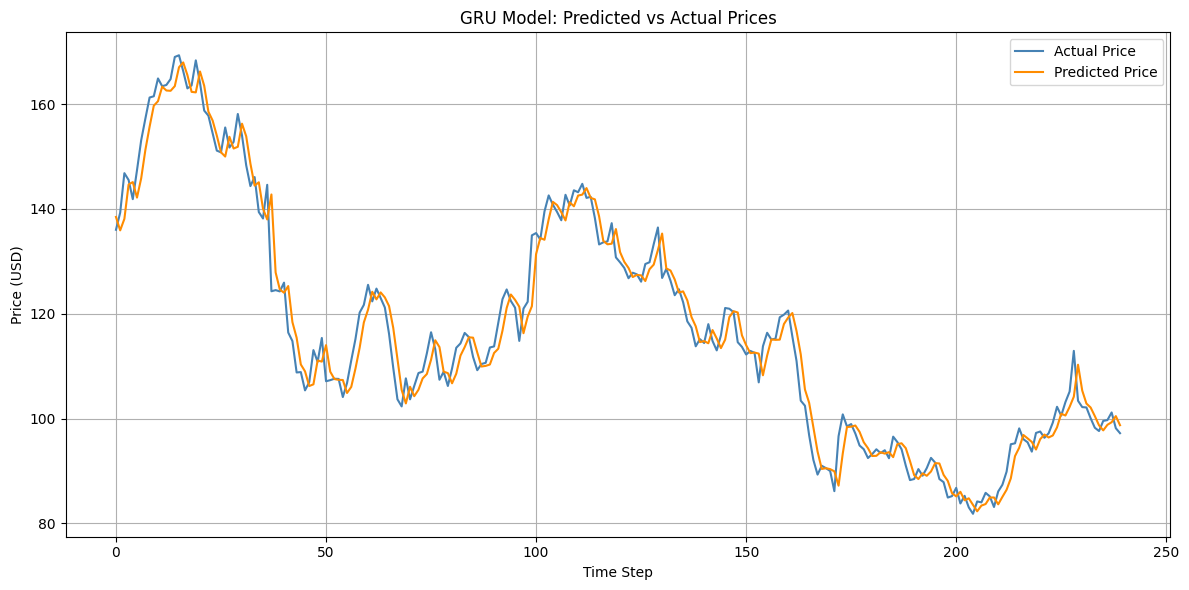

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
GRU Forecast Evaluation Metrics:
MAE : 2.9193
RMSE: 3.8274
MAPE: 0.0251


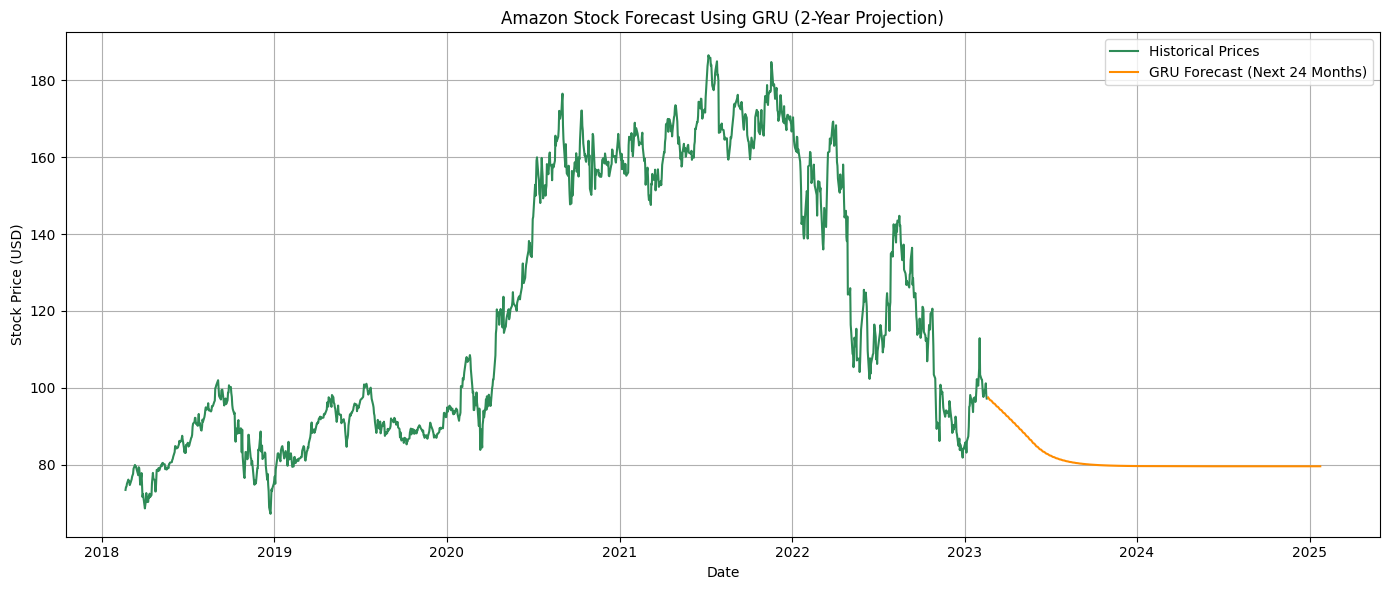

In [4]:
# ---------------------------------------------
# Step 1: Import Essential Libraries for GRU Forecasting
# ---------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

# ---------------------------------------------
# Step 2: Load and Scale the Closing Price Data
# ---------------------------------------------
df_amazon = pd.read_csv("/content/drive/MyDrive/AMZN.csv")
df_amazon['Date'] = pd.to_datetime(df_amazon['Date'])
df_amazon.set_index('Date', inplace=True)

closing_series = df_amazon[['Close']].copy()

# Apply Min-Max scaling to the price data
scaler = MinMaxScaler()
closing_series['Close'] = scaler.fit_transform(closing_series[['Close']])

# ---------------------------------------------
# Step 3: Construct Time Series Sequences
# ---------------------------------------------
def create_time_windows(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

window_size = 60
X_data, y_data = create_time_windows(closing_series['Close'].values, window_size)
X_data = X_data.reshape((X_data.shape[0], X_data.shape[1], 1))

# ---------------------------------------------
# Step 4: Split Data for Training and Testing
# ---------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)

# ---------------------------------------------
# Step 5: Build and Train the GRU Neural Network
# ---------------------------------------------
gru_model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

gru_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ---------------------------------------------
# Step 6: Visualize GRU Predictions vs Actual Prices
# ---------------------------------------------
def plot_gru_predictions(model, X_input, y_actual, title='GRU'):
    y_pred = model.predict(X_input)
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(y_actual.reshape(-1, 1)), label='Actual Price', color='steelblue')
    plt.plot(scaler.inverse_transform(y_pred), label='Predicted Price', color='darkorange')
    plt.title(f"{title} Model: Predicted vs Actual Prices")
    plt.xlabel("Time Step")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_gru_predictions(gru_model, X_test, y_test)

# ---------------------------------------------
# Step 7: Evaluate GRU Model Performance
# ---------------------------------------------
y_pred_scaled = gru_model.predict(X_test)
actual_vals = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
predicted_vals = scaler.inverse_transform(y_pred_scaled).flatten()

gru_mae = mean_absolute_error(actual_vals, predicted_vals)
gru_rmse = np.sqrt(mean_squared_error(actual_vals, predicted_vals))
gru_mape = mean_absolute_percentage_error(actual_vals, predicted_vals)

print("GRU Forecast Evaluation Metrics:")
print("MAE :", round(gru_mae, 4))
print("RMSE:", round(gru_rmse, 4))
print("MAPE:", round(gru_mape, 4))

# ---------------------------------------------
# Step 8: Forecast the Next 24 Months (504 Business Days)
# ---------------------------------------------
def predict_future_gru(model, recent_values, steps=504, window=60):
    last_window = recent_values[-window:].reshape(1, window, 1)
    forecasted = []

    for _ in range(steps):
        next_pred = model.predict(last_window, verbose=0)[0][0]
        forecasted.append(next_pred)
        last_window = np.append(last_window[:, 1:, :], [[[next_pred]]], axis=1)

    return scaler.inverse_transform(np.array(forecasted).reshape(-1, 1))

future_preds = predict_future_gru(gru_model, closing_series['Close'].values)

# ---------------------------------------------
# Step 9: Create Timeline and Plot Future Forecast
# ---------------------------------------------
future_dates = pd.date_range(start=closing_series.index[-1] + pd.DateOffset(days=1), periods=504, freq='B')

plt.figure(figsize=(14, 6))
plt.plot(closing_series.index, scaler.inverse_transform(closing_series['Close'].values.reshape(-1, 1)),
         label='Historical Prices', color='seagreen')
plt.plot(future_dates, future_preds, label='GRU Forecast (Next 24 Months)', color='darkorange')
plt.title('Amazon Stock Forecast Using GRU (2-Year Projection)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
